In [1]:
import os
import cv2
import csv
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torch import nn,optim
from torch.nn import functional as F
from torchvision import transforms 
from torchvision import models as m
from torch.utils.data import DataLoader
import torch
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
import datetime
import gc  #garbage collector
import json
from timm.models.vision_transformer import VisionTransformer
from torchinfo import summary
import cv2
# 导入对应的模型
# from model import swin_tiny_patch4_window7_224 as create_model

In [2]:
torch.cuda.manual_seed(1412)
torch.cuda.manual_seed_all(1412)
torch.manual_seed(420)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#执行此代码时注意关闭VPN
Res50 = m.resnet50(pretrained=True) #resnet18_pretrained
#将导入的预训练模型中所有的参数锁住
for param in Res50.parameters():
    param.requires_grad = False

In [5]:
num_ftrs =Res50.fc.in_features  # 获取低级特征维度
Res50.fc = nn.Linear(num_ftrs, 4)

In [6]:
model =Res50.to(device)

# 打印模型摘要
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)  # 保证随机结果可复现
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root)

    # 遍历文件夹，一个文件夹对应一个类别
    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    # 排序，保证各平台顺序一致
    flower_class.sort()
    # 生成类别名称以及对应的数字索引
    class_indices = dict((k, v) for v, k in enumerate(flower_class))
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    train_images_path = []  # 存储训练集的所有图片路径
    train_images_label = []  # 存储训练集图片对应索引信息
    val_images_path = []  # 存储验证集的所有图片路径
    val_images_label = []  # 存储验证集图片对应索引信息
    every_class_num = []  # 存储每个类别的样本总数
    supported = [".jpg", ".JPG", ".png", ".PNG"]  # 支持的文件后缀类型
    # 遍历每个文件夹下的文件
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        # 遍历获取supported支持的所有文件路径
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        # 排序，保证各平台顺序一致
        images.sort()
        # 获取该类别对应的索引
        image_class = class_indices[cla]
        # 记录该类别的样本数量
        every_class_num.append(len(images))
        # 按比例随机采样验证样本
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  # 如果该路径在采样的验证集样本中则存入验证集
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  # 否则存入训练集
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num)))
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))
    assert len(train_images_path) > 0, "number of training images must greater than 0."
    assert len(val_images_path) > 0, "number of validation images must greater than 0."
    
    plot_image = False
    if plot_image:
        # 绘制每种类别个数柱状图
        plt.bar(range(len(flower_class)), every_class_num, align='center')
        # 将横坐标0,1,2,3,4替换为相应的类别名称
        plt.xticks(range(len(flower_class)), flower_class)
        # 在柱状图上添加数值标签
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # 设置x坐标
        plt.xlabel('image class')
        # 设置y坐标
        plt.ylabel('number of images')
        # 设置柱状图的标题
        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label

In [8]:
class MyDataSet():
    """自定义数据集"""

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])
        # RGB为彩色图片，L为灰度图片
        if img.mode != 'RGB':
            raise ValueError("image: {} isn't RGB mode.".format(self.images_path[item]))
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    @staticmethod
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [11]:
data_path = "/home/ubuntu/fy/diabetic retinopathy/feature selection/data/seg_VB_tofeature"

In [12]:
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(data_path)

1200 images were found in the dataset.
961 images for training.
239 images for validation.


In [13]:
img_size = 224
data_transform = {
        "train": transforms.Compose([
#                                      transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([
#                                  transforms.Resize(int(img_size * 1.143)),
#                                    transforms.CenterCrop(img_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

# 实例化训练数据集
train_dataset = MyDataSet(images_path=train_images_path,
                              images_class=train_images_label,
                               transform=data_transform["train"]
                         )

# 实例化验证数据集
val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                           transform=data_transform["val"]
                       )



In [14]:
batch_size=32
batchdata = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               collate_fn=train_dataset.collate_fn)


testdata = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             collate_fn=val_dataset.collate_fn)


dataloaders = {'train': batchdata , 'val': testdata }
dataset_sizes = {'train': len( batchdata), 'val': len(testdata)}

In [15]:
from torch.optim import lr_scheduler

import copy

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.Adam(model.parameters())

# 定义学习率调度器
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 开始训练模型
num_epochs = 100
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# 初始化记录器
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # 每个epoch都有一个训练和验证阶段
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # 遍历数据
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 零参数梯度
            optimizer.zero_grad()

            # 前向
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # 只在训练模式下进行反向和优化
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # 统计
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

        # 记录每个epoch的loss和accuracy
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # 深拷贝模型
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

print('Best val Acc: {:4f}'.format(best_acc))

# 加载最佳模型权重
#model.load_state_dict(best_model_wts)
#torch.save(model, 'shufflenet_best_model.pth')
#print("The trained model has been saved.")

Epoch 0/99
----------
train Loss: 39.8486 Acc: 13.5484
val Loss: 42.0903 Acc: 11.1250

Epoch 1/99
----------
train Loss: 38.8293 Acc: 13.8065
val Loss: 37.5113 Acc: 14.5000

Epoch 2/99
----------
train Loss: 36.3366 Acc: 15.6452
val Loss: 35.8683 Acc: 14.6250

Epoch 3/99
----------
train Loss: 34.7070 Acc: 15.8387
val Loss: 35.5754 Acc: 15.6250

Epoch 4/99
----------
train Loss: 34.9011 Acc: 16.0968
val Loss: 38.4497 Acc: 15.0000

Epoch 5/99
----------
train Loss: 33.7637 Acc: 16.7097
val Loss: 38.0659 Acc: 15.1250

Epoch 6/99
----------
train Loss: 33.6612 Acc: 17.0323
val Loss: 36.0961 Acc: 15.5000

Epoch 7/99
----------
train Loss: 32.4856 Acc: 17.1935
val Loss: 36.1668 Acc: 15.2500

Epoch 8/99
----------
train Loss: 31.6057 Acc: 17.5484
val Loss: 37.9291 Acc: 12.0000

Epoch 9/99
----------
train Loss: 31.5530 Acc: 17.5484
val Loss: 36.2224 Acc: 14.5000

Epoch 10/99
----------
train Loss: 30.6093 Acc: 18.3548
val Loss: 37.0243 Acc: 15.0000

Epoch 11/99
----------
train Loss: 30.2793

train Loss: 19.3043 Acc: 23.8387
val Loss: 45.5499 Acc: 12.8750

Epoch 94/99
----------
train Loss: 23.7867 Acc: 22.0968
val Loss: 46.7914 Acc: 14.8750

Epoch 95/99
----------
train Loss: 20.6775 Acc: 23.1613
val Loss: 43.9790 Acc: 14.0000

Epoch 96/99
----------
train Loss: 22.3405 Acc: 21.7419
val Loss: 43.8012 Acc: 15.2500

Epoch 97/99
----------
train Loss: 21.8639 Acc: 22.3226
val Loss: 47.5237 Acc: 11.7500

Epoch 98/99
----------
train Loss: 21.3050 Acc: 22.6774
val Loss: 43.2073 Acc: 14.1250

Epoch 99/99
----------
train Loss: 19.2115 Acc: 24.0000
val Loss: 44.5834 Acc: 14.3750

Best val Acc: 15.750000


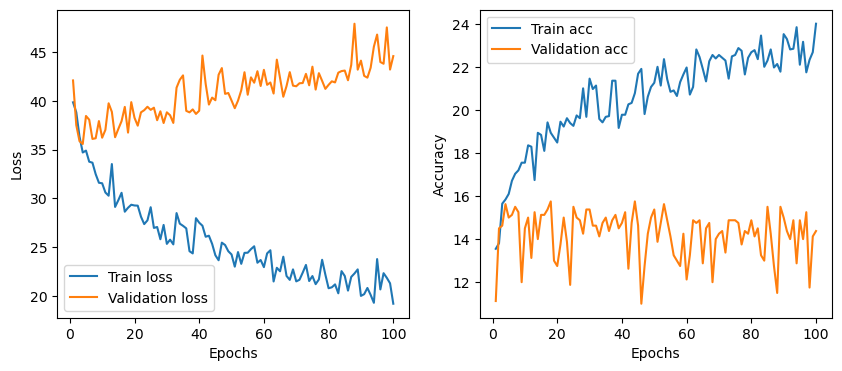

In [16]:

epoch = range(1, len(train_loss_history)+1)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(epoch, train_loss_history, label='Train loss')
ax[0].plot(epoch, val_loss_history, label='Validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epoch, train_acc_history, label='Train acc')
ax[1].plot(epoch, val_acc_history, label='Validation acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

#plt.savefig("loss-acc.pdf", dpi=300,format="pdf")

验证集的灵敏度为： 0.041666666666666664 验证集的特异度为： 0.9404761904761905 验证集的准确率为： 0.7407407407407407 验证集的错误率为： 0.2592592592592593 验证集的精确度为： 0.16666666666666666 验证集的F1为： 0.06666666666666667 验证集的MCC为： -0.03241018617760822
训练集的灵敏度为： 0.7079646017699115 训练集的特异度为： 0.9903381642512077 训练集的准确率为： 0.9297912713472486 训练集的错误率为： 0.0702087286527514 训练集的精确度为： 0.9523809523809523 训练集的F1为： 0.8121827411167513 训练集的MCC为： 0.7829637375700208


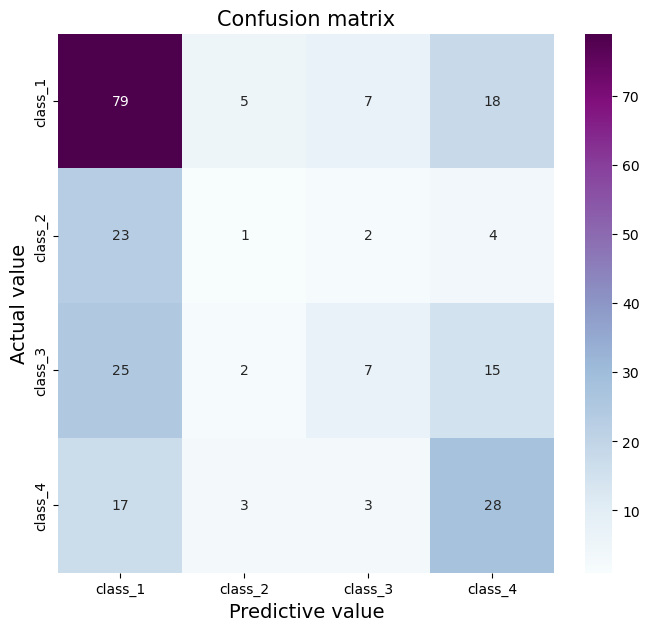

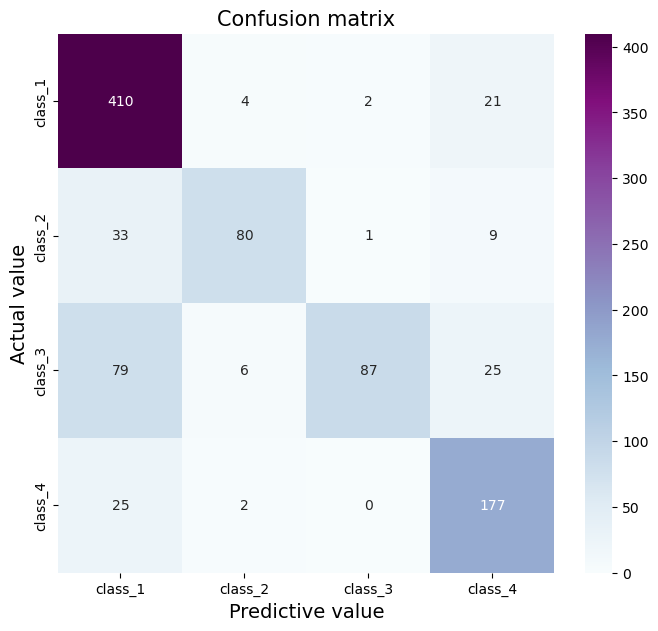

In [18]:

from sklearn.metrics import classification_report, confusion_matrix
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import imshow



class_names = ['class_1','class_2','class_3','class_4']
# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('Confusion matrix',fontsize=15)
    plt.ylabel('Actual value',fontsize=14)
    plt.xlabel('Predictive value',fontsize=14)
    
def evaluate_model(model, dataloader, device):
    model.eval()   # 设置模型为评估模式
    true_labels = []
    pred_labels = []
    # 遍历数据
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 前向
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        
    return true_labels, pred_labels

# 获取预测和真实标签
true_labels, pred_labels = evaluate_model(model, dataloaders['val'], device)

# 计算混淆矩阵
cm_val = confusion_matrix(true_labels, pred_labels)
a_val = cm_val[0,0]
b_val = cm_val[0,1]
c_val = cm_val[1,0]
d_val = cm_val[1,1]

# 计算各种性能指标
acc_val = (a_val+d_val)/(a_val+b_val+c_val+d_val)  # 准确率
error_rate_val = 1 - acc_val  # 错误率
sen_val = d_val/(d_val+c_val)  # 灵敏度
sep_val = a_val/(a_val+b_val)  # 特异度
precision_val = d_val/(b_val+d_val)  # 精确度
F1_val = (2*precision_val*sen_val)/(precision_val+sen_val)  # F1值
MCC_val = (d_val*a_val-b_val*c_val) / (np.sqrt((d_val+b_val)*(d_val+c_val)*(a_val+b_val)*(a_val+c_val)))  # 马修斯相关系数

# 打印出性能指标
print("验证集的灵敏度为：", sen_val, 
      "验证集的特异度为：", sep_val,
      "验证集的准确率为：", acc_val, 
      "验证集的错误率为：", error_rate_val,
      "验证集的精确度为：", precision_val, 
      "验证集的F1为：", F1_val,
      "验证集的MCC为：", MCC_val)

# 绘制混淆矩阵
plot_cm(true_labels, pred_labels)

    
# 获取预测和真实标签
train_true_labels, train_pred_labels = evaluate_model(model, dataloaders['train'], device)
# 计算混淆矩阵
cm_train = confusion_matrix(train_true_labels, train_pred_labels)  
a_train = cm_train[0,0]
b_train = cm_train[0,1]
c_train = cm_train[1,0]
d_train = cm_train[1,1]
acc_train = (a_train+d_train)/(a_train+b_train+c_train+d_train)
error_rate_train = 1 - acc_train
sen_train = d_train/(d_train+c_train)
sep_train = a_train/(a_train+b_train)
precision_train = d_train/(b_train+d_train)
F1_train = (2*precision_train*sen_train)/(precision_train+sen_train)
MCC_train = (d_train*a_train-b_train*c_train) / (math.sqrt((d_train+b_train)*(d_train+c_train)*(a_train+b_train)*(a_train+c_train))) 
print("训练集的灵敏度为：",sen_train, 
      "训练集的特异度为：",sep_train,
      "训练集的准确率为：",acc_train, 
      "训练集的错误率为：",error_rate_train,
      "训练集的精确度为：",precision_train, 
      "训练集的F1为：",F1_train,
      "训练集的MCC为：",MCC_train)

# 绘制混淆矩阵
plot_cm(train_true_labels, train_pred_labels)

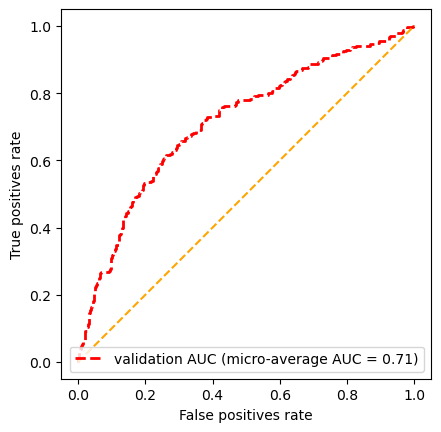

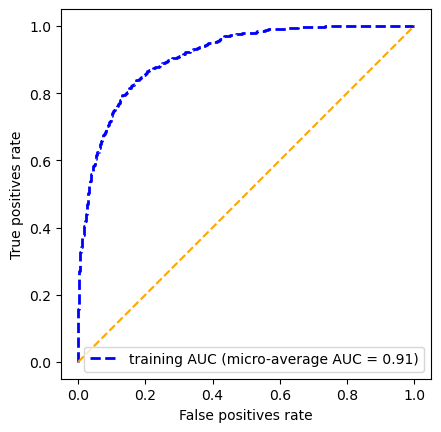

训练集的AUC值为： 0.9240759046552234 验证集的AUC值为： 0.6327176328162387


In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import pandas as pd
import math

def plot_roc_micro(name, labels, predictions, class_names, **kwargs):
    # Compute micro-average ROC curve and ROC AUC score
    fpr, tpr, _ = metrics.roc_curve(pd.get_dummies(labels).values.ravel(), predictions.ravel())
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the micro-average ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=name+' (micro-average AUC = {0:.2f})'.format(roc_auc), linewidth=2, **kwargs)
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    plt.legend(loc='lower right')
    ax = plt.gca()
    ax.set_aspect('equal')

# Assuming you have defined `class_names` as a list of four class names
class_names = ['Class_1', 'Class_2', 'Class_3', 'Class_4']

val_pre_auc = []
val_label_auc = []
train_ds = dataloaders['train']
val_ds = dataloaders['val']
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_ds:
        images = images.to(device)
        labels = labels.to(device)
        predictions_auc = model(images)
        val_pre_auc.append(predictions_auc.cpu().numpy())  # Output probabilities for all classes
        val_label_auc.append(labels.cpu().numpy())

val_pre_auc = np.vstack(val_pre_auc)
val_label_auc = np.hstack(val_label_auc)

plot_roc_micro('validation AUC', val_label_auc, val_pre_auc, class_names, color="red", linestyle='--')

# Compute the ROC AUC score for the validation set
auc_score_val = metrics.roc_auc_score(pd.get_dummies(val_label_auc), val_pre_auc, multi_class='ovr')

train_pre_auc = []
train_label_auc = []

model.train()  # Set the model back to training mode
with torch.no_grad():
    for images, labels in train_ds:
        images = images.to(device)
        labels = labels.to(device)
        predictions_auc = model(images)
        train_pre_auc.append(predictions_auc.cpu().numpy())
        train_label_auc.append(labels.cpu().numpy())

train_pre_auc = np.vstack(train_pre_auc)
train_label_auc = np.hstack(train_label_auc)

plot_roc_micro('training AUC', train_label_auc, train_pre_auc, class_names, color="blue", linestyle='--')

# Compute the ROC AUC score for the training set
auc_score_train = metrics.roc_auc_score(pd.get_dummies(train_label_auc), train_pre_auc, multi_class='ovr')

plt.legend(loc='lower right')
plt.show()

print("训练集的AUC值为：", auc_score_train, "验证集的AUC值为：", auc_score_val)


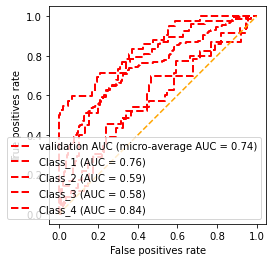

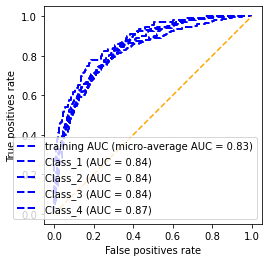

训练集的AUC值为： 0.8476104417273131 验证集的AUC值为： 0.6916720511187242


In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import pandas as pd
import math

def plot_roc_multiclass(name, labels, predictions, class_names, **kwargs):
    # Compute the ROC curve for each class separately (one-vs-all)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = metrics.roc_curve(labels == i, predictions[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC AUC score
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(pd.get_dummies(labels).values.ravel(), predictions.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # Plot the ROC curves for each class and the micro-average ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label=name+' (micro-average AUC = {0:.2f})'.format(roc_auc["micro"]), linewidth=2, **kwargs)
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label='{0} (AUC = {1:.2f})'.format(class_names[i], roc_auc[i]), linewidth=2, **kwargs)
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    plt.legend(loc='lower right')
    ax = plt.gca()
    ax.set_aspect('equal')

# Assuming you have defined `class_names` as a list of four class names
class_names = ['Class_1', 'Class_2', 'Class_3', 'Class_4']


val_pre_auc = []
val_label_auc = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_ds:
        images = images.to(device)
        labels = labels.to(device)
        predictions_auc = model(images)
        val_pre_auc.append(predictions_auc.cpu().numpy())  # Output probabilities for all classes
        val_label_auc.append(labels.cpu().numpy())

val_pre_auc = np.vstack(val_pre_auc)
val_label_auc = np.hstack(val_label_auc)

plot_roc_multiclass('validation AUC', val_label_auc, val_pre_auc, class_names, color="red", linestyle='--')

# Compute the ROC AUC score for the validation set
auc_score_val = metrics.roc_auc_score(pd.get_dummies(val_label_auc), val_pre_auc, multi_class='ovr')

train_pre_auc = []
train_label_auc = []

model.train()  # Set the model back to training mode
with torch.no_grad():
    for images, labels in train_ds:
        images = images.to(device)
        labels = labels.to(device)
        predictions_auc = model(images)
        train_pre_auc.append(predictions_auc.cpu().numpy())
        train_label_auc.append(labels.cpu().numpy())

train_pre_auc = np.vstack(train_pre_auc)
train_label_auc = np.hstack(train_label_auc)

plot_roc_multiclass('training AUC', train_label_auc, train_pre_auc, class_names, color="blue", linestyle='--')

# Compute the ROC AUC score for the training set
auc_score_train = metrics.roc_auc_score(pd.get_dummies(train_label_auc), train_pre_auc, multi_class='ovr')

plt.legend(loc='lower right')
plt.show()

print("训练集的AUC值为：", auc_score_train, "验证集的AUC值为：", auc_score_val)

